# Using word embeddings

Another popular and powerful way to associate a vector with a word is the use of dense _word vectors_, also called **word embeddings**. While the vectors obtained through one-hot encoding are binary, sparse (mostly made of zeros) and very high-dimensional (same dimensionality as the number of words in the vocabulary), _word embeddings_ are low-dimensional floating point vectors (i.e. _dense vectors_, as opposed to sparse vectors). Unlike word vectors obtained via one-hot encoding, **word embeddings are learned from data**. It is common to see word embeddings that are 256-dimensional, 512-dimensional, or 1024-dimensional when dealing with very large vocabularies. On the other hand, one-hot encoding words generally leads to vectors that are 20,000-dimensional or higher (capturing a vocabulary of 20,000 token in this case). So, **word embeddings pack more information into far fewer dimensions**.

<img src="./resources/onehot-vs-embedding.png" width=500>

There are **two ways to obtain word embeddings**:

- **Learn word embeddings jointly with the main task you care about** (e.g. document classification or sentiment prediction). In this setup, you would start with random word vectors, then learn your word vectors in the same way that you learn the weights of a neural network.
- **Load into your model word embeddings that were pre-computed using a different machine learning task** than the one you are trying to solve. These are called _pre-trained word embeddings_.

## Learning word embeddings with the `Embedding` layer

The simplest way to associate a dense vector to a word would be to **pick the vector at random**. The problem with this approach is that the resulting embedding space would have no structure: for instance, the words "accurate" and "exact" may end up with **completely different embeddings, even though they are interchangeable in most sentences**. **It would be very difficult for a deep neural network to make sense of such a noisy, unstructured embedding space.**

To get a bit more abstract: **the geometric relationships between word vectors should reflect the semantic relationships between these words**. Word embeddings are meant to map human language into a geometric space. For instance, in a reasonable embedding space, we would expect synonyms to be embedded into similar word vectors, and in general we would expect the geometric distance (e.g. L2 distance) between any two word vectors to relate to the semantic distance of the associated words (words meaning very different things would be embedded to points far away from each other, while related words would be closer). Even beyond mere distance, we may want specific directions in the embedding space to be meaningful.


In real-world word embedding spaces, **common examples of meaningful geometric transformations are "_gender vectors_" and "_plural vector_"**. For instance, by adding a "female vector" to the vector "king", one obtain the vector "queen". By adding a "plural vector", one obtain "kings". Word embedding spaces typically feature thousands of such interpretable and potentially useful vectors.

**What makes a good word embedding space depends heavily on your task**: the perfect word embedding space for an English-language movie review sentiment analysis model may look very different from the perfect embedding space for an English-language legal document classification model, because **the importance of certain semantic relationships varies from task to task**.

**It is thus reasonable to learn a new embedding space with every new task**. Thankfully, backpropagation makes this really easy, and Keras makes it even easier. It's just about learning the weights of a layer: the `Embedding` layer.

In [1]:
from tensorflow.keras import layers

# The Embedding layer takes at least two arguments:
# 1) the number of possible tokens, here 1000 (1 + maximum word index),
# 2) the dimensionality of the embeddings, here 64.
embedding_layer = layers.Embedding(1000, 64)

The Embedding layer **takes as input a 2D tensor of integers**, of shape (`samples, sequence_length`), where each entry is a sequence of integers. It **returns a 3D floating-point tensor** of shape(`samples, sequence_length, embedding_dimensionality`).
The Embedding layer is best understood as a **dictionary mapping integer indices (which stand for specific words) to dense vectors**. It takes as input integers, it looks up these integers into an internal dictionary, and it returns the associated vectors. It's effectively a dictionary lookup.

When you instantiate an Embedding layer, its **weights (its internal dictionary of token vectors) are initially random**, just like with any other layer. **During training, these word vectors will be gradually adjusted via backpropagation**, structuring the space into something that the downstream model can exploit. Once fully trained, your embedding space will show a lot of structure -- a kind of structure specialized for the specific problem you were training your model for.

Let's apply this idea to the IMDB movie review sentiment prediction, already seen in [this notebook](https://github.com/lucone83/deep-learning-with-python/blob/master/notebooks/chapter_03/01%20-%20Binary%20classifier.ipynb).
We will restrict the movie reviews to the top 10,000 most common words, and cut the reviews after only 20 words. Our network will simply learn 8-dimensional embeddings for each of the 10,000 words, turn the input integer sequences (2D integer tensor) into embedded sequences (3D float tensor), flatten the tensor to 2D, and train a single Dense layer on top for classification.

In [2]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras import preprocessing

# Number of words to consider as features
max_features = 10000

# Cut texts after this number of words (among top max_features most common words)
maxlen = 20

# Load the data as lists of integers.
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Turn our lists of integers into a 2D integer tensor of shape `(samples, maxlen)`
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

In [4]:
from tensorflow.keras.models import Sequential

model = Sequential()
# We specify the maximum input length to our Embedding layer so we can later flatten the embedded inputs
model.add(layers.Embedding(10000, 8, input_length=maxlen))
# After the Embedding layer, our activations have shape `(samples, maxlen, dimensionality(8))`.

# We flatten the 3D tensor of embeddings into a 2D tensor of shape `(samples, maxlen * 8)`
model.add(layers.Flatten())

# We add the classifier on top
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 1s 58us/sample - loss: 0.6570 - accuracy: 0.6513 - val_loss: 0.5949 - val_accuracy: 0.7076
Epoch 2/10
20000/20000 [==============================] - 1s 42us/sample - loss: 0.5222 - accuracy: 0.7583 - val_loss: 0.5146 - val_accuracy: 0.7354
Epoch 3/10
20000/20000 [=========

We get to a validation accuracy of `~76%`, **which is pretty good considering that we only look at the first 20 words in every review**. But note that **merely flattening the embedded sequences and training a single Dense layer on top leads to a model that treats each word in the input sequence separately**, without considering inter-word relationships and structure sentence (e.g. it would likely treat both "this movie is shit" and "this movie is the shit" as being negative "reviews"). **It would be much better to add recurrent layers or 1D convolutional layers on top of the embedded sequences** to learn features that take into account each sequence as a whole.

## Using pre-trained word embeddings

Instead of learning word embeddings jointly with the problem you want to solve, **it could be better to load embedding vectors from a pre-computed embedding space** known to be highly structured and to exhibit useful properties -- that captures generic aspects of language structure. 
The rationale behind using pre-trained word embeddings in natural language processing is very much the same as for using pre-trained convnets in image classification: **we don't have enough data available to learn truly powerful features on our own, but we expect the features that we need to be fairly generic**, i.e. common visual features or semantic features. In this case it makes sense to reuse features learned on a different problem.

There are various pre-computed databases of word embeddings that can download and start using in a Keras `Embedding` layer. _Word2Vec_ is one of them. Another popular one is called _GloVe_, developed by Stanford researchers in 2014. It stands for "Global Vectors for Word Representation", and **it is an embedding technique based on factorizing a matrix of word co-occurrence statistics**. Its developers have made available pre-computed embeddings for millions of English tokens, obtained from _Wikipedia_ data or from _Common Crawl_ data.

Let's take a look at how to get started using GloVe embeddings in a Keras model. The same method will of course be valid for Word2Vec embeddings or any other word embedding database. We will also use this example to refresh the text tokenization techniques: we will start from raw text, and work our way up.

### From raw text to word embeddings

We will be using a model similar to the one we just went over -- embedding sentences in sequences of vectors, flattening them and training a Dense layer on top. But we will do it using pre-trained word embeddings, and instead of using the pre-tokenized IMDB data packaged in Keras, we will start from scratch, by downloading the original text data.

- Head to http://ai.stanford.edu/~amaas/data/sentiment/ and download the raw IMDB dataset (if the URL isn't working anymore, just Google "IMDB dataset");
- Uncompress it;
- Collect the individual training reviews into a list of strings, one string per review, and also collect the review labels (positive / negative) into a labels list;

In [22]:
import os

imdb_dir = './datasets/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

### Tokenize the data

Let's vectorize the texts we collected, and prepare a training and validation split. We will merely be using the concepts we introduced earlier in this section.

**Because pre-trained word embeddings are meant to be particularly useful on problems where little training data is available** (otherwise, task-specific embeddings are likely to outperform them), **we will add the following twist**: we **restrict the training data to its first 200 samples**. So we will be learning to classify movie reviews after looking at just 200 examples.

In [23]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100  # Cut reviews after 100 words
training_samples = 200  # Train on 200 samples
validation_samples = 10000  # Validate on 10000 samples
max_words = 10000  # Consider only the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print(f"Found {len(word_index)} unique tokens.")

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print(f"Shape of data tensor: {data.shape}")
print(f"Shape of label tensor: {labels.shape}")

# Split the data into a training set and a validation set.
# But first, shuffle the data, since we started from data
# where sample are ordered (all negative first, then all positive).
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


### Download the GloVe word embeddings

- Head to https://nlp.stanford.edu/projects/glove/ (where you can learn more about the GloVe algorithm), and download the pre-computed embeddings from 2014 English Wikipedia. It's a 822MB zip file named glove.6B.zip, containing 100-dimensional embedding vectors for 400,000 words (or non-word tokens);
- Un-zip it.

### Pre-process the embeddings

Let's parse the un-zipped file (it's a txt file) to build an index mapping words (as strings) to their vector representation (as number vectors).

In [24]:
glove_dir = './embeddings/glove_6B/'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


Now let's build an embedding matrix that we will be able to load into an `Embedding` layer. It must be a matrix of shape (`max_words, embedding_dim`), where each entry `i` contains the embedding_dim-dimensional vector for the word of index `i` in our reference word index (built during tokenization). Note that the index 0 is not supposed to stand for any word or token -- it's a placeholder.

In [25]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

### Define a model

We will be using the same model architecture as before:

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 100, 100)          1000000   
_________________________________________________________________
flatten_12 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_22 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


### Load the GloVe embeddings in the model

The `Embedding` layer has a single weight matrix: a 2D float matrix where each entry i is the word vector meant to be associated with index i. Simple enough. Let's just load the GloVe matrix we prepared into our Embedding layer, the first layer in our model:

In [51]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

Additionally, we freeze the embedding layer (we set its trainable attribute to `False`), following the same rationale used with in the context of pre-trained convnet features: when parts of a model are pre-trained (like our Embedding layer), and parts are randomly initialized (like our classifier), **the pre-trained parts should not be updated during training to avoid forgetting what they already know**. The large gradient update triggered by the randomly initialized layers would be very disruptive to the already learned features.

### Train and evaluate

In [52]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

model.save_weights('./models/pre_trained_glove_model.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 5ms/sample - loss: 0.6407 - acc: 0.6900 - val_loss: 0.7856 - val_acc: 0.5706
Epoch 2/10
200/200 [==============================] - 0s 2ms/sample - loss: 0.0261 - acc: 1.0000 - val_loss: 0.8934 - val_acc: 0.5627
Epoch 3/10
200/200 [==============================] - 0s 2ms/sample - loss: 0.0126 - acc: 1.0000 - val_loss: 0.8500 - val_acc: 0.5754
Epoch 4/10
200/200 [==============================] - 0s 2ms/sample - loss: 0.0073 - acc: 1.0000 - val_loss: 0.9518 - val_acc: 0.5668
Epoch 5/10
200/200 [==============================] - 0s 2ms/sample - loss: 0.0052 - acc: 1.0000 - val_loss: 0.9936 - val_acc: 0.5657
Epoch 6/10
200/200 [==============================] - 0s 2ms/sample - loss: 0.0041 - acc: 1.0000 - val_loss: 1.0019 - val_acc: 0.5654
Epoch 7/10
200/200 [==============================] - 0s 2ms/sample - loss: 0.0031 - acc: 1.0000 - val_loss: 1.0137 - val_acc: 0.5677
Epoch 8/10
200

### Plot performance over time

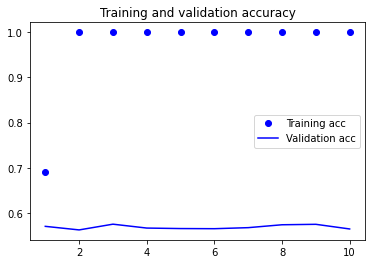

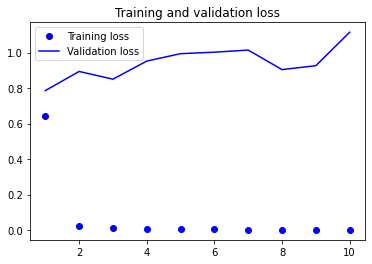

In [53]:
import matplotlib.pyplot as plt

def plot_performance_over_time(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()
    
plot_performance_over_time(history)

The model **quickly starts overfitting**, unsurprisingly given the small number of training samples. Validation accuracy has high variance for the same reason, but seems to reach high 50s.

Since we have so few training samples, performance is heavily dependent on which exact 200 samples we picked, and we picked them at random. If it worked really poorly for you, try picking a different random set of 200 samples, just for the sake of the exercise (in real life you don't get to pick your training data).

We can also try to train the same model without loading the pre-trained word embeddings and without freezing the embedding layer. In that case, we would be learning a task-specific embedding of our input tokens, which is generally more powerful than pre-trained word embeddings when lots of data is available. However, in our case, we have only 200 training samples. Let's try it:

In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 100, 100)          1000000   
_________________________________________________________________
flatten_13 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_24 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 4ms/sample - loss: 0.6920 - acc: 0.5350 - val_loss: 0.6922 - val_acc: 0.5119
Epoch 2/10
200/200 [==============================] - 0s 2m

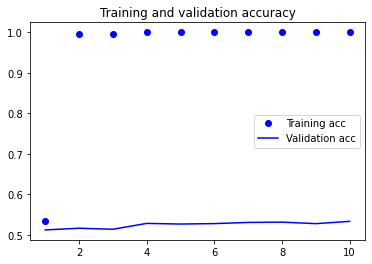

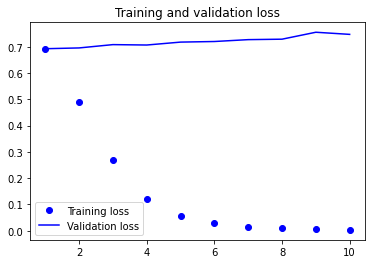

In [55]:
plot_performance_over_time(history)

Validation accuracy stalls in the low 50s. So in our case, pre-trained word embeddings does outperform jointly learned embeddings. If we increase the number of training samples, this will quickly stop being the case. Let's try it with an alternative model:

In [40]:
training_samples = 800 # Increase training set to 1000
validation_samples = 1000

alt_x_train = data[:training_samples]
alt_y_train = labels[:training_samples]
alt_x_val = data[training_samples: training_samples + validation_samples]
alt_y_val = labels[training_samples: training_samples + validation_samples]


alt_model = Sequential()
alt_model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
alt_model.add(Flatten())
alt_model.add(Dense(32, activation='relu'))
alt_model.add(Dense(1, activation='sigmoid'))

alt_model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = alt_model.fit(alt_x_train, alt_y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(alt_x_val, alt_y_val))

Train on 800 samples, validate on 1000 samples
Epoch 1/10
800/800 [==============================] - 1s 730us/sample - loss: 0.6935 - acc: 0.5100 - val_loss: 0.6916 - val_acc: 0.5330
Epoch 2/10
800/800 [==============================] - 0s 190us/sample - loss: 0.4624 - acc: 0.9712 - val_loss: 0.7034 - val_acc: 0.5400
Epoch 3/10
800/800 [==============================] - 0s 191us/sample - loss: 0.1535 - acc: 0.9950 - val_loss: 0.6982 - val_acc: 0.5720
Epoch 4/10
800/800 [==============================] - 0s 185us/sample - loss: 0.0345 - acc: 0.9975 - val_loss: 0.7059 - val_acc: 0.5830
Epoch 5/10
800/800 [==============================] - 0s 192us/sample - loss: 0.0085 - acc: 1.0000 - val_loss: 0.7385 - val_acc: 0.6020
Epoch 6/10
800/800 [==============================] - 0s 184us/sample - loss: 0.0020 - acc: 1.0000 - val_loss: 0.7574 - val_acc: 0.6020
Epoch 7/10
800/800 [==============================] - 0s 186us/sample - loss: 5.1629e-04 - acc: 1.0000 - val_loss: 0.7921 - val_acc: 0.59

#### Evaluation
Finally, let's evaluate the model with pre-trained embeddings on the test data. First, we will need to tokenize the test data:

In [56]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [57]:
# Load and evaluate the model
model.load_weights('./models/pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 1s 31us/sample - loss: 1.1504 - acc: 0.5541


[1.150428861064911, 0.55412]

We get an appalling test accuracy of 55%. Working with just a handful of training samples is hard!